# CPlink tutorial for ST data

Here, we provide a simplified and fast demonstration of **CPlink** on PDAC ST data and bulk RNA-seq data that include both tumor and healthy samples. The bulk RNA-seq data were obtained from [Wu et al.](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171485), and the ST data was obtained from [Moncada et al](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3036911).

The processed data in matrix format also can be obtained from [here](https://github.com/jiaojhua/CPlink_analysis/tree/main/Testdata/ST)

In [1]:
library(DESeq2)
library(Seurat)
library(ggplot2)
library(CPlink)
library(CelliD)

载入需要的程辑包：S4Vectors

载入需要的程辑包：stats4

载入需要的程辑包：BiocGenerics


载入程辑包：‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



载入程辑包：‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


载入需要的程辑包：IRanges

载入需要的程辑包：GenomicRanges

载入需要的程辑包：GenomeInfoDb

载入需要的程辑包：SummarizedExperiment

载入需要的程辑包：MatrixGenerics

载入需要的程辑包：matrixStats


载入程辑包：‘MatrixGenerics’


The following objects are m

In [2]:
setwd("~/ST/")

# Load data

In [3]:
bulk_count <- readRDS("bulk_count.rds")
bulk_meta <- readRDS("bulk_meta.rds")

st_count <- readRDS("sc_count.rds")
position <- readRDS("position.rds")
label <- read.csv("label_new.csv", row.names=1)

# Preprocessing of scRNA-seq data

In [4]:
seurat_obj <- runSpatial(st_count, label[colnames(st_count), ])

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


# Identifying phenotype-specific peaks from bulk RNA-seq data and getting spot-spot similarity graph and data matrix from ST

In [5]:
bulk_meta$phenotype <- factor(bulk_meta$phenotype)
bulk_meta$phenotype <- relevel(bulk_meta$phenotype, ref = "Normal")
DESeq2_Sig_Genes <- runDESeq2(bulk_count, bulk_meta, design_formula = ~ phenotype, p.adj = 0.05)
DEGs_mtx <- data.frame(markers=rownames(DESeq2_Sig_Genes[[2]]), logFC=DESeq2_Sig_Genes[[2]]$log2FoldChange)
rownames(DEGs_mtx) <- rownames(DESeq2_Sig_Genes[[2]])
DEGs <- DEGs_mtx$markers

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 62 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 62 workers



In [6]:
data_matrix <- as.matrix(GetAssayData(seurat_obj, slot = "data"))

combined_snn <- getCOSNN(seurat_obj, 0.2, position, seurat_obj@graphs$SCT_snn)

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”
Computing nearest neighbor graph

Computing SNN



# Run CPlink

In [7]:
CPlink_out_mtx <- runCPlink(data_matrix, DEGs_mtx, snn = combined_snn, seed_ratio = NULL, restart_prob = NULL, 
                            sim_methods = "cosine", SigThreshold = 0.05)

Starting CPlink pipeline

Running MCA on phenotype-specific features

Computing Fuzzy Matrix



0.005 sec elapsed


Computing SVD



0.06 sec elapsed


Computing Coordinates



0.002 sec elapsed


Calculating initial phenotype association scores

Restart Probability: 0.05; Seeds Ratio: 0.99

Computing empirical p-values and assign CPlink+ / CPlink- labels

CPlink run completed successfully



# Attach CPlink results to Seurat meta.data

In [8]:
seurat_obj <- seurat_obj
seurat_obj@meta.data <- cbind(seurat_obj@meta.data, 
                                  cbind(CPlink_out_mtx[[1]], CPlink_out_mtx[[2]])[rownames(seurat_obj@meta.data),])

# Visualization

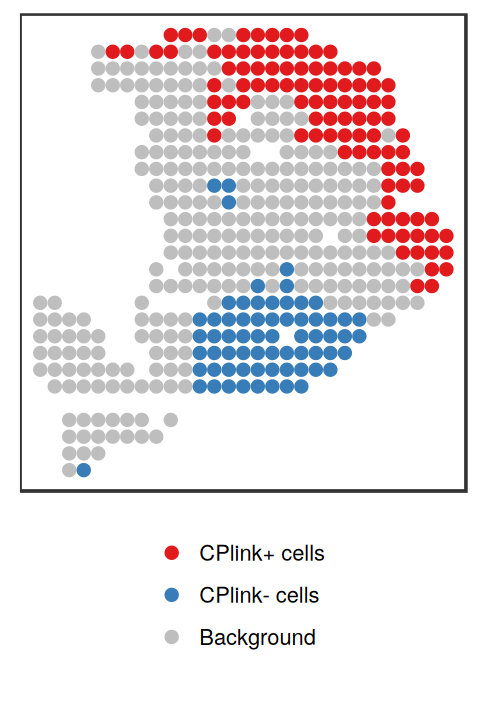

In [9]:
col_p <-c("#e11a1d", "#387db8", "grey" )
seurat_obj@meta.data$cellLabels <- factor(seurat_obj@meta.data$cellLabels, levels=c("CPlink+ cells", "CPlink- cells", "Background"))

options(repr.plot.width=4, repr.plot.height=6)
ggplot(seurat_obj@meta.data, aes(x = coord1, y = coord2)) + 
  geom_point(data = seurat_obj@meta.data, aes(color=cellLabels),size=3) +
 scale_color_manual(values = col_p) +
guides(color = guide_legend(nrow = 4, byrow = TRUE))+
  theme_bw(base_size = 16, base_rect_size = 1)+
 theme(panel.grid = element_blank(), axis.ticks = element_blank(),
           legend.position = "bottom",
           #panel.border = element_blank(),
           axis.text = element_blank(),
           axis.title = element_blank(),
           plot.title = element_text( colour = "black", hjust = 0.5),
          legend.text = element_text( colour = "black"),
       legend.title = element_blank()
          
         # axis.line = element_line(linewidth = 0.5, arrow = arrow(type = "closed"))
          )

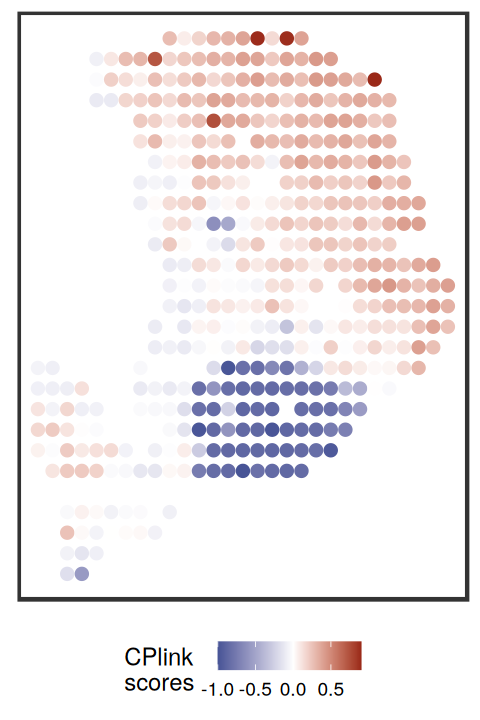

In [10]:
ggplot(seurat_obj@meta.data, aes(x = coord1, y = coord2, color = CPlinkScore)) + 
  geom_point(size = 3) +
scale_color_gradient2(
    low      = "#475496", 
    mid      = "white",    
    high     = "darkred",  
    midpoint = -0      
  ) +
  labs(color = "CPlink \nscores") +
  theme_bw(base_size = 14, base_rect_size = 1.5) +
 theme(panel.grid = element_blank(), axis.ticks = element_blank(),
           legend.position = "bottom",
           axis.text = element_blank(),
           axis.title = element_blank(),
           plot.title = element_text( colour = "black", hjust = 0.5),
          legend.text = element_text( colour = "black")
          )

In [11]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.10

Matrix products: default
BLAS/LAPACK: /home/server/anaconda3/envs/CPlinkTest/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=zh_CN.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=zh_CN.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=zh_CN.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] CelliD_1.10.1               SingleCellExperiment_1.22.0
 [3] CPlink_0.1.0                ggplot2_3.5.1              
 [5] SeuratObject_5.0.2          Seurat_4.4.0               
 [7] DESeq2_1.42.1            